# Exploring a curated multi-image classification dataset in fastai with more details

- Walkthrough of how to train a model that classifies multiple objects in the same image
- This version of the notebook includes additional techniques for getting details about the performance of the model as well as exercising the model on the test dataset
- This notebook is inspired by this Kaggle kernel: https://www.kaggle.com/jachen36/coco-tiny-test-prediction


In [1]:
# imports for notebook boilerplate
!pip install -Uqq fastbook
import fastbook
import os
from fastbook import *
from fastai.vision.all import *

In [2]:
# set up the notebook for fast.ai
fastbook.setup_book()

In [3]:
# plot_metrics function from https://forums.fast.ai/t/plotting-metrics-after-learning/69937/3 courtesy of Ignacio Oguiza
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    print("metrics is ",metrics)
    names = self.metric_names[1:-1]
    print("names is ", names)
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    print("axs is",axs)
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        print("i is",i)
        print("name is",name)
        print("ax is",ax)
        if i < 2:
            ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
            ax.set_title(name if i > 1 else 'losses')
            ax.legend(loc='best')
    plt.show()

# Ingest the dataset

In [4]:
path = untar_data(URLs.PASCAL_2007)

In [5]:
path.ls()

(#8) [Path('/storage/data/pascal_2007/train'),Path('/storage/data/pascal_2007/test.json'),Path('/storage/data/pascal_2007/segmentation'),Path('/storage/data/pascal_2007/train.json'),Path('/storage/data/pascal_2007/valid.json'),Path('/storage/data/pascal_2007/test.csv'),Path('/storage/data/pascal_2007/train.csv'),Path('/storage/data/pascal_2007/test')]

# Examine the dataset

In [6]:
# bring the structures in the train.json file into Python
with open(path/'train.json') as json_file:
    data = json.load(json_file)
    # each nested structure is a list of dictionaries
    categories = data['categories']
    images = data['images']
    annotations = data['annotations']  
   

In [7]:
print("categories ", categories)
print()
print("subset of images",list(images)[:5])
print()
print("subset of annotations",list(annotations)[:5])

categories  [{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}, {'supercategory': 'none', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'none', 'id': 3, 'name': 'bird'}, {'supercategory': 'none', 'id': 4, 'name': 'boat'}, {'supercategory': 'none', 'id': 5, 'name': 'bottle'}, {'supercategory': 'none', 'id': 6, 'name': 'bus'}, {'supercategory': 'none', 'id': 7, 'name': 'car'}, {'supercategory': 'none', 'id': 8, 'name': 'cat'}, {'supercategory': 'none', 'id': 9, 'name': 'chair'}, {'supercategory': 'none', 'id': 10, 'name': 'cow'}, {'supercategory': 'none', 'id': 11, 'name': 'diningtable'}, {'supercategory': 'none', 'id': 12, 'name': 'dog'}, {'supercategory': 'none', 'id': 13, 'name': 'horse'}, {'supercategory': 'none', 'id': 14, 'name': 'motorbike'}, {'supercategory': 'none', 'id': 15, 'name': 'person'}, {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'}, {'supercategory': 'none', 'id': 17, 'name': 'sheep'}, {'supercategory': 'none', 'id': 18, 'name': 'sofa'}, {'supercatego

In [8]:
# define a Python dictionary for the contents of the train.json file
image_files, bbox_lbl = get_annotations(path/'train.json')
img_bbox_combo = dict(zip(image_files, bbox_lbl))

In [9]:
bbox_lbl[0:4]

[([[155, 96, 351, 270]], ['car']),
 ([[184, 61, 279, 199], [89, 77, 403, 336]], ['person', 'horse']),
 ([[8, 229, 245, 500],
   [229, 219, 334, 500],
   [1, 177, 90, 500],
   [1, 0, 117, 369],
   [2, 1, 243, 462],
   [224, 0, 334, 486]],
  ['bicycle', 'bicycle', 'bicycle', 'person', 'person', 'person']),
 ([[89, 124, 337, 212]], ['car'])]

In [10]:
# examine the bounding box and labels for one of the image files
img_bbox_combo[image_files[1]][1]

['person', 'horse']

In [11]:
# get the label for one of bounding boxes for one of the image files
img_bbox_combo[image_files[5]][1][0]

'aeroplane'

In [12]:
image_files[5]

'000033.jpg'

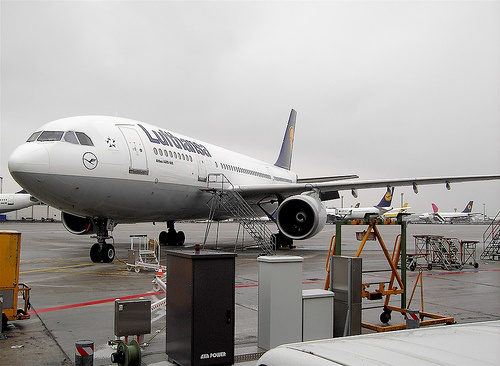

In [13]:
# look at one of the images
image_subpath = 'train/'+image_files[5]
img = PILImage.create(path/image_subpath)
img

# Prepare the data and define the dataloaders object

In [14]:
# function to return the value corresponding with a key in a list of dictionaries
def get_category(in_key_value,in_key,out_key,dict_list):
    return([cat[out_key] for cat in dict_list if cat[in_key]==in_key_value] )

In [15]:
# exercise os.path.basename
os.path.basename('/storage/data/pascal_2007/train/006635.jpg')

'006635.jpg'

In [16]:
def label_func(x): return get_category(get_category(os.path.basename(x),'file_name','id',images)[0],'image_id','bbox',annotations)

In [17]:
# return the bounding box for a given filename
def get_bbox(filename):
    return np.array(img_bbox_combo[os.path.basename(filename)][0])

In [18]:
# return the label (category) for a given filename
def get_lbl(filename):
    return np.array(img_bbox_combo[os.path.basename(filename)][1],dtype=object)

In [19]:
get_lbl('/storage/data/pascal_2007/train/006635.jpg')

array(['train'], dtype=object)

In [20]:
#get_lbl('/storage/data/pascal_2007/train/003772.jpg')

In [21]:
get_lbl('/storage/data/pascal_2007/train/007911.jpg')


array(['motorbike', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person'], dtype=object)

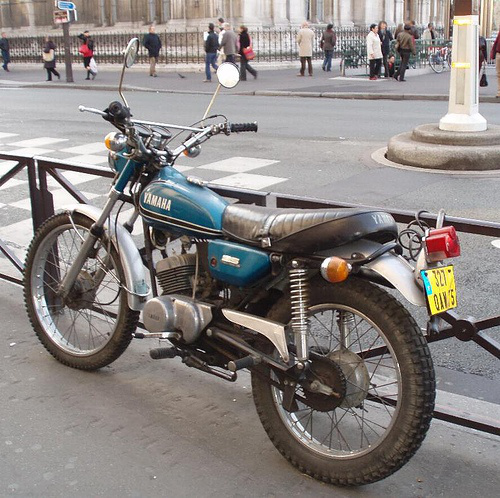

In [22]:
image_subpath = 'train/007911.jpg'
img = PILImage.create(path/image_subpath)
img

In [23]:
# get the image ID for a given image file from the training set
file_path = Path('/storage/data/pascal_2007/train/008513.jpg')
get_category(os.path.basename(file_path),'file_name','id',images)


[]

In [24]:
# print the size of the training and test sets
print("number of training images: ",len(get_image_files(path/'train')))
print("number of testing images: ",len(get_image_files(path/'test')))

number of training images:  5011
number of testing images:  4952


In [25]:
# print the number of categories in the annotations
print("number of categories is: ",len(categories))

number of categories is:  20


In [26]:
# get a set of image file names from the training set
get_image_files(path/'train')[0:5]

(#5) [Path('/storage/data/pascal_2007/train/003772.jpg'),Path('/storage/data/pascal_2007/train/006066.jpg'),Path('/storage/data/pascal_2007/train/003767.jpg'),Path('/storage/data/pascal_2007/train/006547.jpg'),Path('/storage/data/pascal_2007/train/008444.jpg')]

In [27]:
# exercise the get_lbl function for a given image file from the training set
get_lbl(Path('/storage/data/pascal_2007/train/006547.jpg'))

array(['cat'], dtype=object)

In [28]:
# get the image ID for a given image file from the training set
get_category(os.path.basename(Path('/storage/data/pascal_2007/train/003772.jpg')),'file_name','id',images)

[]

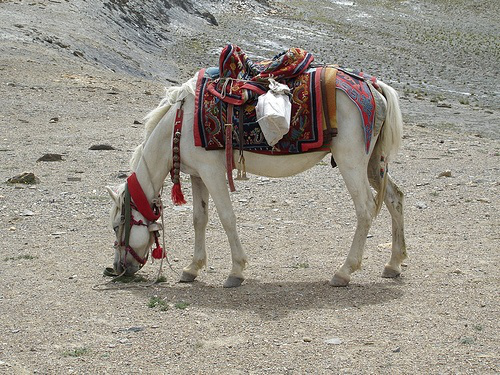

In [29]:
# view the image
image_subpath = 'train/003772.jpg'
img = PILImage.create(path/image_subpath)
img

In [30]:
# define a function to return the set of image files with valid annotations
def get_items(noop):
    return_list = []
    empty_list = []
    # filter the training files and keep only the ones with valid info in the JSON file
    for file_path in get_image_files(path/'train'):
        file_id_list = get_category(os.path.basename(file_path),'file_name','id',images)
        if len(file_id_list) > 0:
            return_list.append(file_path)
        else:
            empty_list.append(file_path)
    print("len(return_list): ",len(return_list))
    print("len(empty_list): ",len(empty_list))
    return(return_list)
        
        

In [31]:
return_list = get_items("junk")

len(return_list):  2501
len(empty_list):  2510


In [32]:
# define a DataBlock object using the get_items and get_lbl functions
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                 get_items = get_items, 
                 splitter=RandomSplitter(),
                 get_y=[get_lbl],
                 item_tfms = RandomResizedCrop(168, min_scale=0.7),
                 n_inp=1)
#                  batch_tfms=aug_transforms(mult=4),

In [33]:
# define a dataloders object using the DataBlock object
dls = db.dataloaders(path,bs=32)

len(return_list):  2501
len(empty_list):  2510


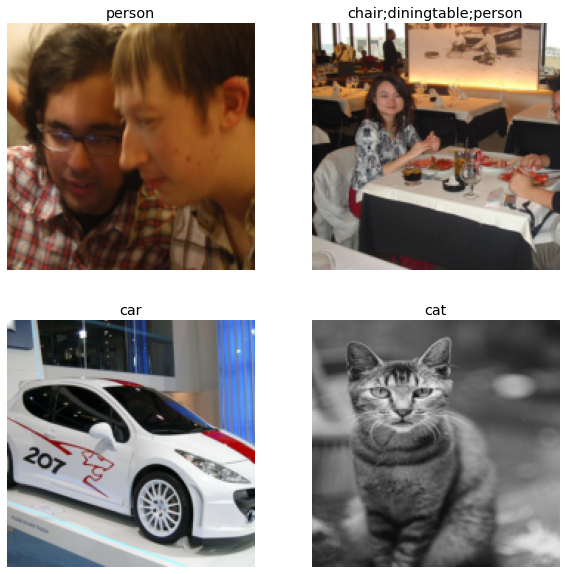

In [34]:
# display a batch 
dls.show_batch(max_n=4, figsize=(10,10))

In [35]:
print("categories ", categories)

categories  [{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}, {'supercategory': 'none', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'none', 'id': 3, 'name': 'bird'}, {'supercategory': 'none', 'id': 4, 'name': 'boat'}, {'supercategory': 'none', 'id': 5, 'name': 'bottle'}, {'supercategory': 'none', 'id': 6, 'name': 'bus'}, {'supercategory': 'none', 'id': 7, 'name': 'car'}, {'supercategory': 'none', 'id': 8, 'name': 'cat'}, {'supercategory': 'none', 'id': 9, 'name': 'chair'}, {'supercategory': 'none', 'id': 10, 'name': 'cow'}, {'supercategory': 'none', 'id': 11, 'name': 'diningtable'}, {'supercategory': 'none', 'id': 12, 'name': 'dog'}, {'supercategory': 'none', 'id': 13, 'name': 'horse'}, {'supercategory': 'none', 'id': 14, 'name': 'motorbike'}, {'supercategory': 'none', 'id': 15, 'name': 'person'}, {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'}, {'supercategory': 'none', 'id': 17, 'name': 'sheep'}, {'supercategory': 'none', 'id': 18, 'name': 'sofa'}, {'supercatego

In [36]:
print("subset of annotations",list(annotations)[:5])

subset of annotations [{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}, {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]], 'area': 13110, 'iscrowd': 0, 'image_id': 17, 'bbox': [184, 61, 95, 138], 'category_id': 15, 'id': 2, 'ignore': 0}, {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]], 'area': 81326, 'iscrowd': 0, 'image_id': 17, 'bbox': [89, 77, 314, 259], 'category_id': 13, 'id': 3, 'ignore': 0}, {'segmentation': [[8, 229, 8, 500, 245, 500, 245, 229]], 'area': 64227, 'iscrowd': 0, 'image_id': 23, 'bbox': [8, 229, 237, 271], 'category_id': 2, 'id': 4, 'ignore': 0}, {'segmentation': [[229, 219, 229, 500, 334, 500, 334, 219]], 'area': 29505, 'iscrowd': 0, 'image_id': 23, 'bbox': [229, 219, 105, 281], 'category_id': 2, 'id': 5, 'ignore': 0}]


# Define and train the model

In [37]:
# define the model
learn = cnn_learner(dls, resnet18,metrics=accuracy_multi)

 

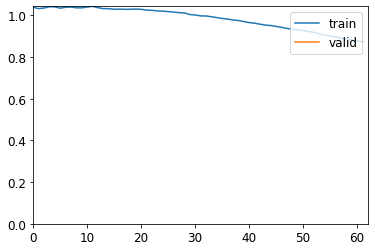

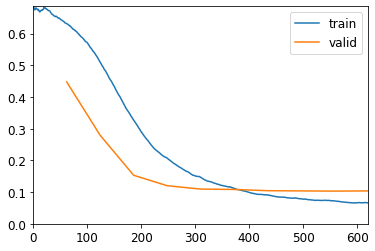

CPU times: user 1min 22s, sys: 16.3 s, total: 1min 38s
Wall time: 1min 51s


In [38]:
%%time
# fine tune the pre-trained model
learn.fine_tune(10,cbs=ShowGraphCallback())

# Exercise the model

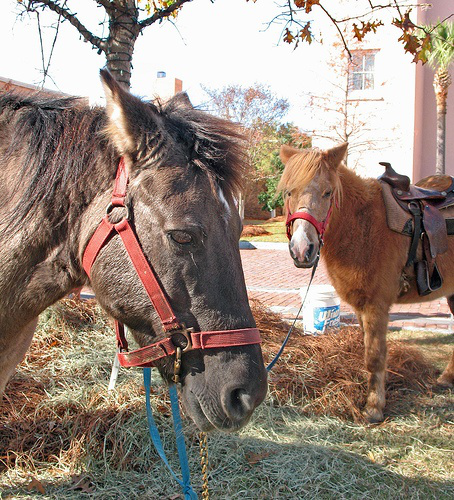

In [39]:
# display an image from the test set
img_test_files = get_image_files(path/"test")
img2 = PILImage.create(img_test_files[100])
img2

In [40]:
# exercise the trained model on this image
learn.predict(img2)

((#2) ['horse','person'],
 TensorImage([False, False, False, False, False, False, False, False, False, False, False, False,  True, False,  True, False, False, False, False, False]),
 TensorImage([0.0062, 0.0134, 0.0025, 0.0103, 0.0106, 0.0099, 0.0212, 0.0095, 0.0025, 0.0189, 0.0018, 0.3588, 0.6625, 0.0101, 0.9686, 0.0062, 0.0026, 0.0308, 0.0080, 0.0039]))

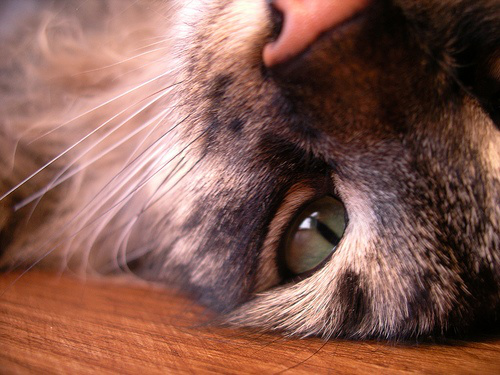

In [41]:
# display another image from the test set
img3 = PILImage.create(img_test_files[200])
img3

In [42]:
# exercise the trained model on this image
learn.predict(img3)

((#1) ['cat'],
 TensorImage([False, False, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False, False]),
 TensorImage([7.3240e-04, 1.1102e-03, 5.4663e-03, 3.4045e-03, 1.3662e-03, 3.4992e-03, 1.1123e-03, 9.0643e-01, 5.0203e-03, 1.9261e-02, 1.1044e-03, 2.0779e-03, 4.3229e-02, 2.0339e-03, 3.4322e-03, 1.2341e-03,
         3.5900e-03, 2.4660e-03, 2.9050e-03, 5.5935e-03]))

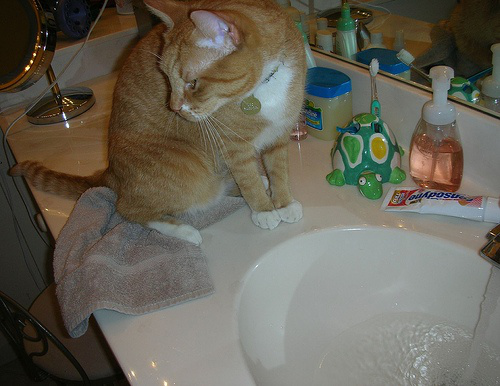

In [43]:
# display another image from the test set
img4 = PILImage.create(img_test_files[120])
img4

In [44]:
# exercise the trained model on this image
learn.predict(img4)

((#1) ['cat'],
 TensorImage([False, False, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False, False]),
 TensorImage([0.0009, 0.0253, 0.0028, 0.0062, 0.0819, 0.0037, 0.0075, 0.7229, 0.0292, 0.0030, 0.0250, 0.0484, 0.0015, 0.0072, 0.2051, 0.1045, 0.0041, 0.1085, 0.0016, 0.0148]))

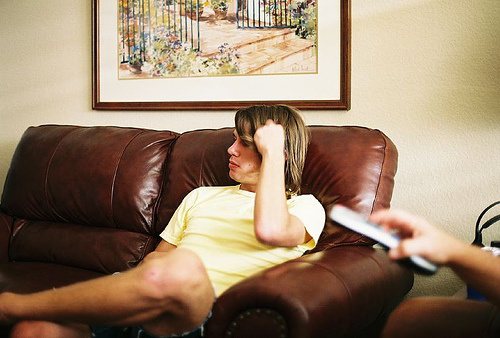

In [45]:
# display another image from the test set
img5 = PILImage.create(img_test_files[150])
img5

In [46]:
# exercise the trained model on this image
learn.predict(img5)

((#1) ['person'],
 TensorImage([False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True, False, False, False, False, False]),
 TensorImage([1.6128e-03, 1.1829e-03, 4.7744e-03, 2.5270e-03, 9.2828e-02, 4.5031e-03, 9.9569e-03, 1.5908e-02, 1.7766e-01, 4.5477e-03, 4.4713e-02, 2.0738e-02, 1.1242e-01, 7.3662e-04, 9.9786e-01, 8.3360e-02,
         1.8136e-03, 9.0781e-02, 1.0219e-03, 8.7878e-03]))

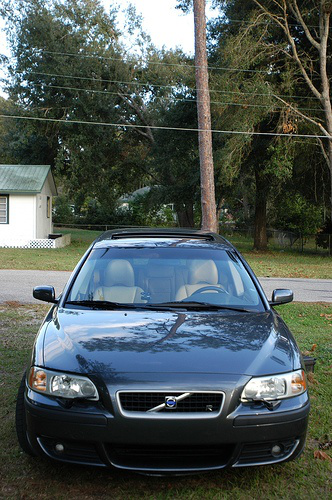

In [47]:
# display another image from the test set
img6 = PILImage.create(img_test_files[900])
img6

In [48]:
# exercise the trained model on this image
learn.predict(img6)

((#1) ['car'],
 TensorImage([False, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False, False, False]),
 TensorImage([4.3201e-03, 2.4805e-03, 5.0147e-03, 9.7032e-03, 1.7515e-03, 5.5690e-03, 9.9260e-01, 1.0535e-03, 6.1064e-03, 3.8250e-03, 5.5376e-03, 1.9120e-03, 1.2191e-03, 2.5502e-03, 6.0446e-02, 6.4624e-03,
         3.4825e-03, 6.0155e-03, 1.0885e-02, 7.1703e-04]))

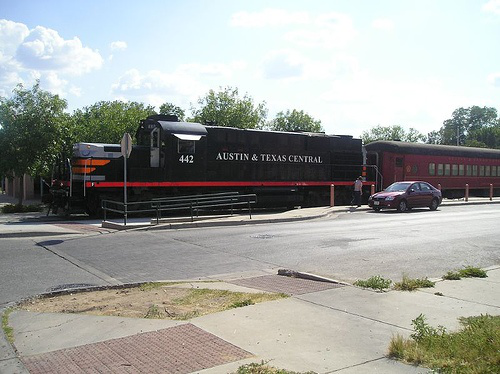

In [49]:
# display another image from the test set
img7 = PILImage.create(img_test_files[950])
img7

In [50]:
# exercise the trained model on this image
learn.predict(img7)

((#1) ['train'],
 TensorImage([False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True, False]),
 TensorImage([3.7282e-02, 4.6247e-03, 1.1320e-03, 1.2311e-03, 3.6792e-03, 5.2827e-02, 1.2453e-01, 1.2750e-03, 1.8062e-03, 1.9889e-03, 5.3752e-04, 2.4764e-03, 1.1118e-03, 2.8400e-03, 1.5200e-02, 4.1685e-03,
         1.1063e-03, 3.6402e-03, 9.8551e-01, 2.5305e-03]))

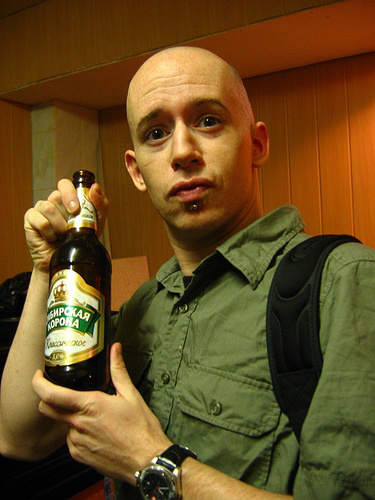

In [51]:
# display another image from the test set
img8 = PILImage.create(img_test_files[800])
img8

In [52]:
learn.predict(img8)

((#2) ['bottle','person'],
 TensorImage([False, False, False, False,  True, False, False, False, False, False, False, False, False, False,  True, False, False, False, False, False]),
 TensorImage([1.3032e-03, 5.8453e-03, 9.1799e-03, 2.0697e-03, 8.3794e-01, 4.2306e-03, 3.1740e-03, 4.2553e-03, 8.0111e-03, 4.6875e-04, 3.6903e-03, 2.1115e-02, 2.7775e-03, 8.0307e-03, 9.9813e-01, 1.5557e-02,
         2.0784e-03, 1.4033e-02, 2.1171e-03, 5.7353e-03]))

# Examine the performance of the model

In [53]:
# get the accuracy for the validation set
learn.validate()

(#2) [0.10378039628267288,0.9651000499725342]

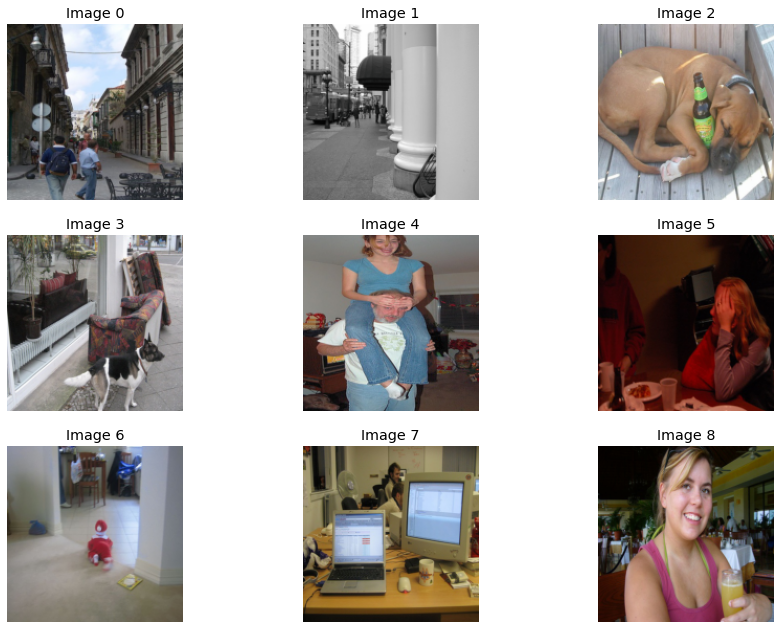

In [54]:
# show the predictions with the greatest losses
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

# Get accuracy for the test set

In [55]:
# load the test annotations into Python structures
with open(path/'test.json') as json_file:
    data_test = json.load(json_file)
    # each nested structure is a list of dictionaries
    categories_test = data_test['categories']
    images_test = data_test['images']
    annotations_test = data_test['annotations'] 

In [56]:
# define a temporary writeable path for saving the model
if 'google.colab' in str(get_ipython()):
    temp_path = Path('/content/gdrive/MyDrive/fastai_cookbook/Deep-Learning-with-fastai-Cookbook/ch3/')
else:
    temp_path = Path(os.getcwd())
learn.path = temp_path

In [57]:
temp_path

Path('/notebooks/fastai2/Deep-Learning-with-fastai-Cookbook/ch8')

In [58]:
# save the model
learn.save('saved_model_july16')

Path('/notebooks/fastai2/Deep-Learning-with-fastai-Cookbook/ch8/models/saved_model_july16.pth')

In [59]:
# define a function to return the set of image files with valid annotations from the test set
def get_items_test(noop):
    return_list = []
    empty_list = []
    # filter the training files and keep only the ones with valid info in the JSON file
    for file_path in get_image_files(path/'test'):
        file_id_list = get_category(os.path.basename(file_path),'file_name','id',images_test)
        if len(file_id_list) > 0:
            return_list.append(file_path)
        else:
            empty_list.append(file_path)
    return(return_list)

In [60]:
# define a Python dictionary for the contents of the test.json file
image_files_test, bbox_lbl_test = get_annotations(path/'test.json')
img_bbox_combo_test = dict(zip(image_files_test, bbox_lbl_test))

In [61]:
# return the label (category) for a given filename
def get_lbl_test(filename):
    return np.array(img_bbox_combo_test[os.path.basename(filename)][1],dtype=object)

In [62]:
# define a DataBlock object using the get_items_test and get_lbl_test functions
db2 = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                 get_items = get_items_test, 
                 splitter=RandomSplitter(),
                 get_y=[get_lbl_test],
                 item_tfms = RandomResizedCrop(168, min_scale=0.7),
                 n_inp=1)
#                  batch_tfms=aug_transforms(mult=4),

In [63]:
# define a dataloders object using the DataBlock object
dls2 = db2.dataloaders(path,bs=32)

In [64]:
learn2 = cnn_learner(dls2, resnet18,metrics=accuracy_multi)

In [65]:
# set the model path the same path where the trained model was saved
learn2.path = temp_path


In [66]:
# load the weights from the trained model
learn2.load('saved_model_july16')

In [67]:
# get the accuracy for the model on the test set
learn2.validate(cbs=ShowGraphCallback())

(#2) [0.10375692695379257,0.9650000333786011]

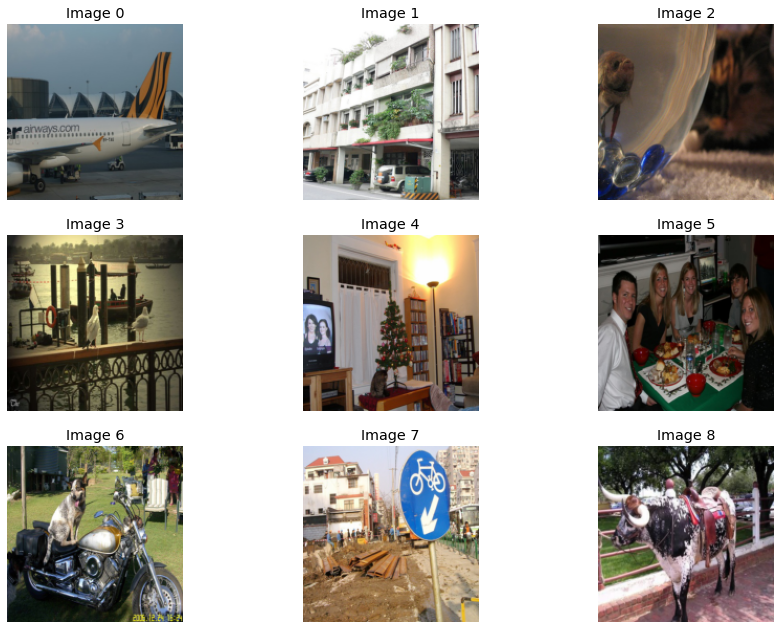

In [68]:
interp2 = ClassificationInterpretation.from_learner(learn2)
losses,idxs = interp2.top_losses()
interp2.plot_top_losses(9, figsize=(15,11))

# Examine details of the test set

In [69]:
# get the path for a test set file by index
img_test_files[950]

Path('/storage/data/pascal_2007/test/001935.jpg')

In [70]:
# get the annotations for a particular file in the test set
get_category('001935.jpg','file_name','id',images_test)

[1935]

In [71]:
# get the categories of objects identified in image 1935
get_category(1935,'image_id','category_id',annotations_test)

[19, 7, 15]

In [72]:
annotations_test[0:4]

[{'segmentation': [[47, 239, 47, 371, 195, 371, 195, 239]],
  'area': 19536,
  'iscrowd': 0,
  'image_id': 1,
  'bbox': [47, 239, 148, 132],
  'category_id': 12,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[7, 11, 7, 498, 352, 498, 352, 11]],
  'area': 168015,
  'iscrowd': 0,
  'image_id': 1,
  'bbox': [7, 11, 345, 487],
  'category_id': 15,
  'id': 2,
  'ignore': 0},
 {'segmentation': [[138, 199, 138, 301, 207, 301, 207, 199]],
  'area': 7038,
  'iscrowd': 0,
  'image_id': 2,
  'bbox': [138, 199, 69, 102],
  'category_id': 19,
  'id': 3,
  'ignore': 0},
 {'segmentation': [[122, 154, 122, 195, 215, 195, 215, 154]],
  'area': 3813,
  'iscrowd': 0,
  'image_id': 3,
  'bbox': [122, 154, 93, 41],
  'category_id': 18,
  'id': 4,
  'ignore': 0}]